# Optimization problem
we would like to maximise 
$$
\operatorname{\mathbb{E}_{t}}[R_{t}^{P}] - \gamma \operatorname{Var_{t}}[R_{t}^{P}]
$$
with respect to $z_{t}$, under the contraint that $\mathbb{1}^{T}z_{t}=0$. Here, $\gamma$, a _risk aversion parameter_ , with value $\gamma = 1/2$.

In addition, we would like to add the no short-sale constraint 
$$
w_{t}+z_{t} \geq 0.
$$ 

Hence, we would like to pick the $z_{t}$ that solves the optimization problem
$$
\begin{equation}
\begin{aligned}
& \underset{z_{t}\in\mathbb{R}^{n}}{\mathrm{maximize}}
& & R_{t|t}^{T}z_{t} - \gamma (w_{t}+z_{t})^{T}\Sigma_{t|t}(w_{t}+z_{t}) \\
& \text{subject to}
& &  \mathbb{1}^{T}z_{t}=0, \\
& & &  w_{t}+z_{t} \geq 0, \\
\end{aligned}
\end{equation}
$$

for each time $t=1\ldots,T$. However, $R_{t|t}$ and $\Sigma_{t|t}$ are typically not know, but can be replaced by approprate estimates $\hat R_{t|t}$ and $\hat\Sigma_{t|t}$, respectively. Thus, we arrive at the final problem 
$$
\begin{equation}
\begin{aligned}
& \underset{z_{t}\in\mathbb{R}^{n}}{\mathrm{maximize}}
& & \hat R_{t|t}^{T}z_{t} - \gamma (w_{t}+z_{t})^{T}\hat\Sigma_{t|t}(w_{t}+z_{t}) \\
& \text{subject to}
& &  \mathbb{1}^{T}z_{t}=0, \\
& & &  w_{t}+z_{t} \geq 0, \\
\end{aligned}
\end{equation}
$$
that needs to be solved for each time $t=1\ldots,T$.


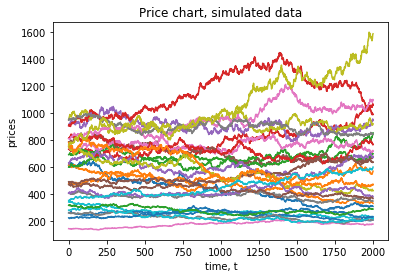

In [1]:
import os
os.chdir(os.path.pardir)

%run Data/simulated_data.ipynb

In [2]:
import cvxpy as cvx

def SPO_mark(hat_R, hat_Sigma, weights, gamma=0.5):
    z = cvx.Variable(len(hat_R.T))
    expected_netReturn = hat_R.T @ z # for each stock, depends on how 
    expected_risk = gamma*cvx.quad_form(weights + z, hat_Sigma) # weights * hat_Sigma * weights.T
    
    utility = expected_netReturn - expected_risk
    objective = cvx.Maximize(utility)

    constraints = [
        cvx.sum(z) == 0, # difference in weights sums up to 0 – portfolio stays fully invested
        weights + z >= 0, # no short sales
    ] 
    prob = cvx.Problem(objective, constraints)
    prob.solve()
    
    return z.value #change of weights

### Prediction value
change yearpred to number of years after $T_0$ that should be predicted. I.e $T_0 + T_{pred} = T$

In [3]:
yearpred = 2
T_pred = yearpred*252

## Function to loop convex optimization for each day of the period

In [4]:
# calc_mu = expected return, cov matrix of returns = Sigma

def loop_optimization(calc_mu, Sigma):
    totValue = np.empty(T+1)
    totValue[0] = 1E6
    weights = np.ones(N)/N # starting with 1/30 invested in all stocks
    R_P = np.zeros(T) # portfolio realized return - fractional increase of portfolio return over the period
    muTemp = mu_old # use the old mu value the first period of optimization & when not predicting return
    
    z = SPO_mark(muTemp, Sigma, weights)# Sigma is the cov matrix of the expected returns
    R_P[0] = R[0].T @ (weights + z)
    totValue[1] = totValue[0] * (1 + R_P[0]) # total value of the whole portfolio
    turnover = np.linalg.norm(z,ord=1)/2
    
    # Iterate over the whole period T and calculate the change of weights by maximazing
    # the risk adjusted return of each period
    for t in range (T-1):
        # if predicting when the time is after T_pred, take the expected/predicted returns day by day
        if (len(calc_mu.T) > N) & (t > T_pred+1):
            muTemp = calc_mu[:,t]
            
        # solve the convex optimization problem for each day
        weights =  (1 + R[t])*(weights + z) / (1+R_P[t]) # next period weights Boyd (2.11)
        z = SPO_mark(muTemp, Sigma, weights) #c

        turnover += np.linalg.norm(z ,ord=1)/2
        R_P[t+1] = R[t+1].T @ (weights + z) # calc the actual return from the new calc weights
        totValue[t+2] = totValue[t+1] * (1 + R_P[t+1])
        
        
    return totValue, turnover, R_P, weights

# Performance metrics
Annualized average turnover is calculated by:
$$
\begin{equation}
\frac{250}{T} \sum_{t=1}^{T}\left\|\left(z_{t}\right)_{1: n}\right\|_{1} / 2
\end{equation}
$$

The _post-trade total value_ of the portfolio, in SEK, given exactly at the beginning of time period $t$, is just $v_{t}$, since
$$
\mathbb{1}^{T}h_{t}^{+} = \mathbb{1}^{T}(h_{t} + u_{t}) = \mathbb{1}^{T}h_{t} + \mathbb{1}^{T} u_{t} = \mathbb{1}^{T}h_{t} = v_{t}, \quad \forall t = 1,\ldots,T.
$$

Assuming that the risk-free rate is zero, the annualized sharpe ratio is given by:
$$
SR = \frac{\overline{R^{P}_{t}}}{\widehat{\sigma}^{P}}.
$$

In [5]:
# function to plot and print the portfolio data
def plot_n_printPortfolio(totValuePrint, turnoverPrint, R_Pprint, name, weightsPrint):
    an_turnover = (turnoverPrint/T)*252 # approx 252 trading days in a year

    print('\033[1m'+name+'\033[0m')
    print('Turnover:',an_turnover.round(6)); print('Total value of portfolio:', totValuePrint[T].round())
    
    #plot the total value of the portfolio over time T
    fig, axes = plt.subplots()
    years = np.arange(T+1)/252
    axes.plot(years, totValuePrint)
    axes.set_xlabel('Year')
    axes.set_ylabel('SEK')
    axes.set_title(name);


    # print the sharpe ratio
    # annualized average of returns
    averageRe = np.mean(R_Pprint)*252
    # annualized standard deviation of returns
    stdSigma = np.std(R_Pprint)*np.sqrt(252)
    sharpeRatio_an = (averageRe/stdSigma)
    print('Sharpe Ratio:', sharpeRatio_an.round(6)); print('Weights at end of period', weightsPrint.round(4))

## Simulate portfolio using true values

True Values
Turnover: 0.588799
Total value of portfolio: 1095433.0
Sharpe Ratio: 0.320387
Weights at end of period [-0.      0.171   0.      0.2649  0.      0.     -0.      0.      0.
 -0.      0.      0.      0.      0.      0.      0.      0.      0.
 -0.     -0.      0.     -0.      0.      0.2399  0.1899  0.      0.
 -0.      0.      0.1343]


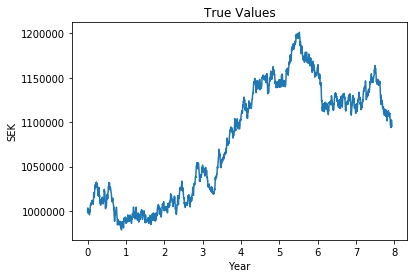

In [6]:
totValue, turnover, R_P, weights = loop_optimization(mu_old, Sigma)
plot_n_printPortfolio(totValue,turnover,R_P, 'True Values', weights)

## Simple moving average
$ SMA = \frac{A^n_1+A^n_2+...+A^n_t}{T}$
<br>Where $A^n_t =$ the return of the stock $n$ at period $t$
<br> $T =$ number of periods
<br><br> _Not using this at the moment_

In [7]:
# Simple moving average from 5 previous periods
nbP = 2
old_smaSum = np.zeros(N)
# calc sma from 5 latest returns
for n in range(0, nbP):
    old_smaSum += R[T_pred-n-1,:]
old_smaSum /= nbP

sma = np.zeros(((len(R)-T_pred, N)))
#calc sma for the rest of the periods (T-T_pred years)
for t in range (T_pred+1, T-1):
    for x in old_smaSum:
        sma[t-T_pred,:] = x + (1/nbP)*(R[t-nbP-1,:] - R[t-1,:])
        old_smaSum = sma[t-T_pred,:]
        
# save the predictions to R array
RsmaTemp = np.zeros((T,N))
for t in range (T_pred,T-1):
    RsmaTemp[t,:] = sma[t-T_pred,:]
    
Rsma = RsmaTemp.T


In [8]:
T_sma = 5
R_hat_sma = R.copy()

for t in range(T_sma, T):
    temp = np.zeros(N)
    for i in range(T_sma):
        temp += R_hat_sma[t-i-1,:]
    R_hat_sma[t,:] = temp/T_sma
        
print(np.shape(R))

(2000, 30)


SMA Predicted Portfolio
Turnover: 180.839144
Total value of portfolio: 1030782.0
Sharpe Ratio: 0.087573
Weights at end of period [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  1. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


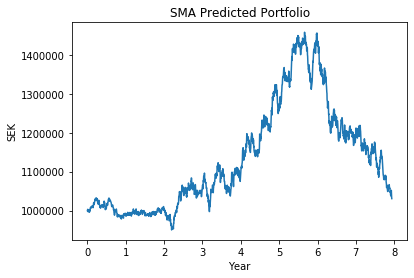

In [9]:
totValueSMA, turnoverSMA, R_Psma, weightsSMA = loop_optimization(Rsma, Sigma)
plot_n_printPortfolio(totValueSMA, turnoverSMA, R_Psma, 'SMA Predicted Portfolio', weightsSMA)

## Exponential Moving Average
Exponential moving average gives more weight to the recent prices and as a result of which, it can be a better model or better capture the movement of the trend in a faster way. EMA's reaction is directly proportional to the pattern of the data.

Let $\alpha_{\text{EMA}}\in (0,1)$ and
$$
\begin{align}
    \hat R_{t|t}^{\text{EMA}} = 
    \begin{cases}
    R_{t-1},              & \text{if } t = 2, \\
    \alpha_{\text{EMA}} \hat R_{t-1|t-1}^{\text{EMA}} + (1 - \alpha_{\text{EMA}}) R_{t-1},              & \text{if } 2 < t \leq T.
    \end{cases}
\end{align}
$$
Often, a variable $\tau_{\text{EMA}}\in\mathbb{N}$ is introduced such that 
$$
\begin{align*}
    \alpha_{\text{EMA}} = 1 - \frac{1}{\tau_{\text{EMA}} + 1},
\end{align*}
$$

In [10]:
import pandas as pd
df_R = pd.DataFrame(R).copy()
tau_ema = 1
for index in df_R.index[T_pred:T-1]:
    if index-T_pred <= 2:
        df_R.iloc[index] = df_R.iloc[index-1]
    else:
        df_R.iloc[index] = df_R.iloc[index-1].ewm(span=50,adjust=False).mean()

R_ewm = df_R.to_numpy().T

EMA Predicted Portfolio
Turnover: 1.114532
Total value of portfolio: 1009864.0
Sharpe Ratio: 0.049887
Weights at end of period [-0.     -0.      0.0815 -0.      0.      0.     -0.     -0.     -0.
  0.4518 -0.      0.     -0.     -0.      0.     -0.      0.4667 -0.
 -0.      0.     -0.     -0.      0.     -0.     -0.     -0.     -0.
 -0.      0.     -0.    ]


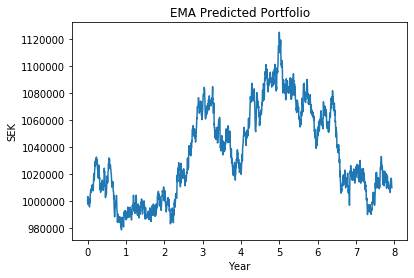

In [11]:
totValueEWM, turnoverEWM, R_Pewm, weightsEWM = loop_optimization(R_ewm, Sigma)
plot_n_printPortfolio(totValueEWM, turnoverEWM, R_Pewm, 'EMA Predicted Portfolio', weightsEWM)